# Informe nº2
    Notas: breve actualización del TFG
    Fecha: 16/04/2020
    
   ## Coordenadas 2D -> 3D + Detección del disco solar mediante su circularidad
    Se describen brevemente los algoritmos que se han utilizado para:
+ Paso de corrdenadas de la imagen(2D) a coordenadas del cielo(3D) con el fin de obtener una imagen no distorsionada y poder deducir la posición del sol real.
+ En el informe anterior se propuso un algoritmo que calculaba la cirularidad del sol para predecir si e disco solar está tapado por nubes o no.

In [13]:
!pip install opencv-python
!pip install matplotlib

import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import glob


## Coordenadas 2D -> 3D
### Calibración de la cámara
    Para poder obtener una poscición del sol correcta, lo primero que debemos hacer es corregir las distorsión que es producidad por la lente tipo ojo de pez. En este tipo de lentes hay dos tipos de distorisón:

In [2]:
%%HTML
<img src="https://docs.opencv.org/2.4/_images/distortion_examples.png"
     alt="Distorsiones"
     style="float: center; margin-right: 5px;" />

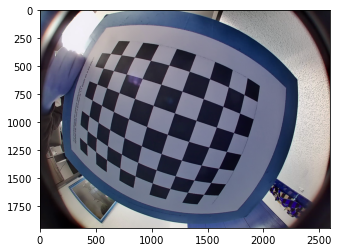

In [20]:
# Ejemplo de imagen tomada por la cámara. Se puede apreciar el tipo de distosión
path =  './imagenes/calibracion/'
path_ref = path + 'referencia/'
path_res = path + 'resultados/'

img_ref = cv2.imread(path_ref + 'image_2020-04-13-13h30min.jpg', cv2.IMREAD_COLOR)

plt.figure(1)
plt.imshow(img_ref)

Como podemos ver en la imagen anterior, esta lente presenta una distorisión radial positiva(o de barril). Este tipo de distorsión es muy frencuente en lentes con gran angulo de visión, como son los ojos de pez. Para solucionar esta distorsión se ha seguido la guía que nos facilita OpenCV. Esta librería dispone de funciones para el calibrado de cámaras mediantes el uso de patrones estilo tablero de ajedrez, como el que se ve en la imágen. Este método se basa en detectar las esquinas de los cuadrados del tablero, identificar sus posiciones en la imágen y obtener las posiciones 3D de estos puntos suponiendo que el trablero esta formado por cuadrados. Para una correcta calibración, se necesitan muchas imágenes del tableero, desde distintos ángulos y distintas distacias. algunas de las ímagenes que se han utilizado de referencia para la calibración se encuentran en *imagenes/calibracion/referencia*

In [15]:
# Código para la calibración de la cámara tomando las imagenes de tablero

# Se define el tamaño del tablero 
CHECKERBOARD = (7,9)

# Criterios para el algoritmo que refina los puntos de las esquinas
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Crea y prepara los vectores de puntos de las esquinas
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)


# VEcores que almacenan los puntos de las esquinas
objpoints = [] # puntos 3d en el espacio real point in real world space
imgpoints = [] # puntos 2d en el plano de la imagen

# Se obtienen todas las imagenes de los tableros
images = glob.glob(path_ref + '*.jpg')

# Se recorren las imagenes
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Encuentra las esquinas de los cuadrados
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    # Si se encuentra algún tablero, se añaden los puntos a los vectores que los almacena
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

# Se calibra la cámara con los vectores de puntos hayados con aterioridad
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Se obtiene una matriz de la cámara optimizada junto con el rectángulo en el que la imagen no-distorionada se ve claramente (roi)
# Si no se ha entendido el concepto de ROI, se explica más adelante
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# Se guarda la calibración realizada en YAML
fname = path + "camera_calibration.yaml"
import yaml

data = {"mtx": mtx.tolist(), "dist": dist.tolist(), 'newcameramtx': newcameramtx.tolist()}

with open(fname, "w") as f:
    yaml.dump(data, f)


Se representa a continuación una imagen original, distorsionada, y dos imágenes sin distorisón:

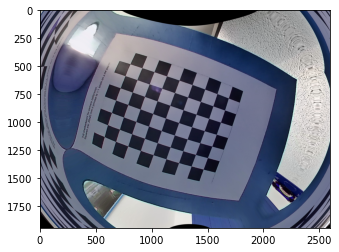

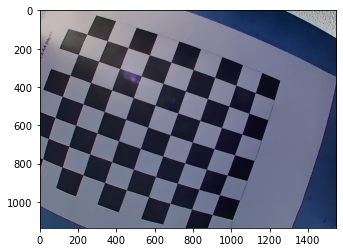

In [19]:
img_org = cv2.imread(path_ref + 'image_2020-04-13-13h30min.jpg', cv2.IMREAD_COLOR)

# Se obtiene la matriz de distorisón de la cámara
import yaml

config_calib = path + 'camera_calibration.yaml'

with open(config_calib, 'r') as file:
    info = yaml.load(file, yaml.FullLoader)
    
    dist = np.array(info['dist'])
    mtx = np.array(info['mtx'])
    newcameramtx = np.array(info['newcameramtx'])
    
    del info

# Se obitiene la matriz de la cámara óptima
# Y el ROI, que representa el rectángulo en el cuál todos los píxeles son "buenos"
# en la imágen sin distorsionar
h,  w = img_org.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))


# Se obtiene la imagen sin ninguna distosión    
img_no_dist = cv2.undistort(img_org, mtx, dist, None, newcameramtx)

#Se imprime la imagén no-distorsionada completa
plt.figure(1)
plt.imshow(img_no_dist)

# Imágen no-distorsionada con parámetro ROI
x, y, w, h = roi
img_no_dist = img_no_dist[y:y+h, x:x+w]
plt.figure(2)
plt.imshow(img_no_dist)

Podemos ver que la imágen no-distorsionada completa, presenta deformaciones en las esquinas. Con el parámetro ROI obtenemos una imágen que es clara y que no presenta ningún tipo de distosión ni deformación. Pero vemos una clara reducción del campo de visión de la cámara, como podemos ver a continuación:

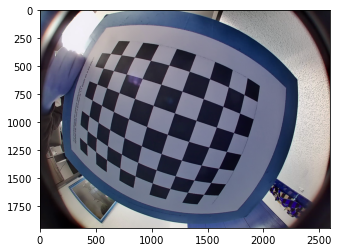

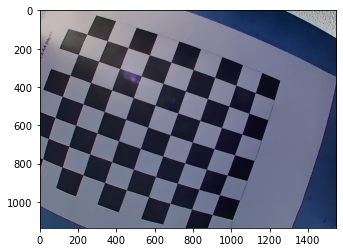

In [21]:
plt.figure(1)
plt.imshow(img_org)
plt.figure(2)
plt.imshow(img_no_dist)

### Obtención de la posición solar real (azimuth y elevación) mediante las coordenadas 3D
Se están llevando a cabo los trabajos sobre está unidad... En unos días estarán disponibles

### Obtencíon del estereorradián al que pertenece un píxel
Se están llevando a cabo los trabajos sobre está unidad... En unos días estarán disponibles

## Detección del disco solar mediante su circularidad
En el informe anterior se vieron varios métodos en los que se detectaban los pixeles saturados con el fin de obtener la posición del sol. Como se vió, en momentos en los que el sol estaba cubierto por nubes, se produce en fenómenos de refraccion de la luz, por el cuál se cambia su dirrección, con lo que los píxeles saturados pueden no ser cercanos al disco solar. Veíamos que con los métodos presentados obteniamos reutados buenos cuando el sol estaba despejado. Por ello, vamos a utilizar algorimos que calculan la circularidad del sol para diferenciar entre los casos en los que el sol está despejado, parcialmente cubierto o cubierto.

### Método utilizando el canal verde y la circularidad del CSP
En el informe anterior se propuso un algorimo de detección del sol mediante el canal verde, pero no se completó. A continuación se ha completado el método añadiendo el cálculo de la circularidad del CSP:

In [34]:
#%% Deteccion del sol con canal verde y circularidad del CSP
def CSP(img_bgr):
    # Vector con los valores del canal verde
    green_img = img_bgr.copy()[:,:,1]

    # Se preparan las máscaras que se van a utilizar
    HBP = np.zeros((img_bgr.shape[0], img_bgr.shape[1]))
    CSP = np.zeros((img_bgr.shape[0], img_bgr.shape[1]))

    for i in range(green_img.shape[0]):
        for j in range(green_img.shape[1]):
            green =  int(green_img[i][j])
            # High brightness pixels (HBP)
            if green > 180:
                HBP[i][j] = 255
                # Circumsolar saturaded pixels(CSP)
                if green > 245:
                    CSP[i][j] = 255

    # Se obtienen los contornos de las figuras que se obtienen en la máscara
    CSP = cv2.medianBlur(CSP.astype(np.uint8),3)
    cnt, hierarchy = cv2.findContours(CSP, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Se obtiene el contorno de mayor área, que debería ser el sol, y se calcula su circularidad, C
    A = 0.0
    for i in cnt:
        temp = cv2.contourArea(i)
        if temp > A:
            A = temp
            L = cv2.arcLength(i, True)

    C = 4 * np.pi * A / L**2
    print('C: ' + str(C))

    HBP = cv2.medianBlur(HBP.astype(np.uint8),5)
    res = cv2.bitwise_and(img_bgr, img_bgr, mask=cv2.bitwise_not(HBP))
    plt.figure(1)
    plt.imshow(img_bgr)
    plt.figure(2)
    plt.imshow(res)

    # En el caso de que la circularidad sea mayor a 0.3 el sol es visible
    if C > 0.8:
        print('Circularidad alta, se ha detectado el sol despejado')
        
    else:
        print('Circularidad muy baja, no se ha detectado el sol')

Veamos ahora este método aplicado a distintas imágenes:

C: 0.8574762207357456
Circularidad alta, se ha detectado el sol despejado


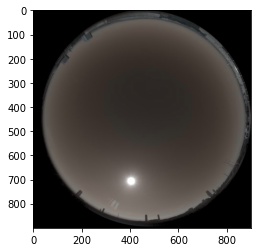

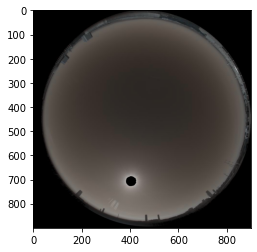

In [37]:
# Cielo despejado
path =  './imagenes/'
file = 'despejado'
despejado_bgr = cv2.imread(path + file + '.png', cv2.IMREAD_COLOR)
CSP(despejado_bgr)

Con un disco solar despejado vemos que el método predice de una forma muy precisa en sol. Pero a continuación lo veremos aplicado a otras imágenes:

C: 0.13692701042499206
Circularidad muy baja, no se ha detectado el sol


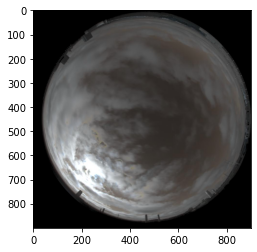

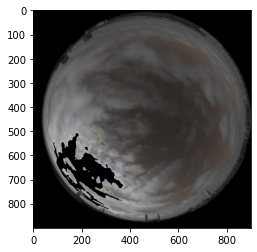

In [38]:
# Cielo con muchas nubes
path =  './imagenes/'
file = 'nubes'
nubes_bgr = cv2.imread(path + file + '.png', cv2.IMREAD_COLOR)
CSP(nubes_bgr)

C: 0.31027276511245827
Circularidad muy baja, no se ha detectado el sol


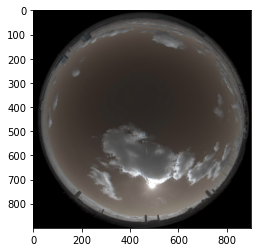

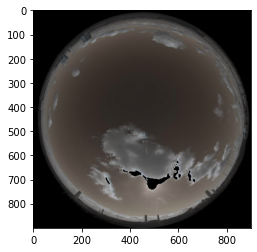

In [39]:
# Cielo con pocas nubes
path =  './imagenes/'
file = 'pocas'
pocas_bgr = cv2.imread(path + file + '.png', cv2.IMREAD_COLOR)
CSP(pocas_bgr)

### 

In [71]:
#%% Detección del sol mediante la transformada de Hough
def Hough(img_bgr, gray):
    circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,1,20,
                                param1=60, param2=30, minRadius=10, maxRadius=70)
    # circles = N vectores de (x, y, radio)
    if circles != None:
        res = img_bgr.copy()
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # draw the outer circle
            cv2.circle(res,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(res,(i[0],i[1]),2,(0,0,255),3)

        return res

In [72]:
def HBP_Hough(img_bgr):
    # Vector con los valores del canal verde
    green_img = img_bgr.copy()[:,:,1]

    # Se preparan las máscaras que se van a utilizar
    HBP = np.zeros((img_bgr.shape[0], img_bgr.shape[1]))
    CSP = np.zeros((img_bgr.shape[0], img_bgr.shape[1]))

    for i in range(green_img.shape[0]):
        for j in range(green_img.shape[1]):
            green =  int(green_img[i][j])
            # High brightness pixels (HBP)
            if green > 180:
                HBP[i][j] = 255
                # Circumsolar saturaded pixels(CSP)
                if green > 245:
                    CSP[i][j] = 255
                    
    res = Hough(img_bgr, HBP.astype(np.uint8))
    plt.figure(1)
    plt.imshow(img_bgr)
    if res != None:
        plt.figure(2)
        plt.imshow(res)

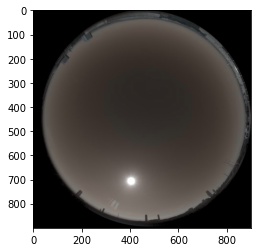

In [73]:
# Cielo despejado
path =  './imagenes/'
file = 'despejado'
despejado_bgr = cv2.imread(path + file + '.png', cv2.IMREAD_COLOR)
HBP_Hough(despejado_bgr)